In [1]:
#%pip install scipy matplotlib

In [2]:
import sys
import os
sys.path.append(os.path.abspath('') + '/build')
import TreeSAT
from TreeSAT import SATTileTree
import numpy as np
import time

In [3]:
input = np.random.rand(50,100,200,1)
tile_sizes = list(range(4,64)) #[4,8,10,16,25,32,48,50,64,128]
sizes = []
timings = []
for tile_size in tile_sizes:
    start = time.time()
    tree = SATTileTree(input, tile_size)
    elapsed = time.time() - start
    sizes.append(tree.size())
    timings.append(elapsed)

tile_sizes = np.array(tile_sizes)
sizes = np.array(sizes) / (1024 * 1024)
timings = np.array(timings)
print(sizes)
with np.printoptions(precision=2):
    print(timings)

[12.087883    9.64361572  9.50536346  9.15991211  8.28796768  8.08599854
  6.37442017  7.7335968   7.80636215  6.44537354  7.35174561  7.2166748
  7.96894836  5.57012939  6.50534058  6.91114807  6.02594757  6.89169312
  7.83640289  7.97716522  8.97880936  4.76959229  5.32208252  5.91558838
  6.55157471  6.32757568  6.96224976  7.63793945  8.35592651  9.11749268
  6.37968445  6.92776489  7.5063324   8.11621094  8.75822449  9.43319702
  8.45163727  9.07110596  9.7201004  10.39930725 11.10941315 11.85110474
 12.62506866 13.43199158 14.27256012 15.14746094  4.28201294  4.53417969
  4.79605103  5.06781006  5.34963989  5.64172363  5.94424438  6.25738525
  6.58132935  6.91625977  7.26235962  7.61981201  7.98880005  8.36950684]
[6.33 4.92 4.68 4.6  3.64 3.72 2.95 3.48 3.48 2.92 3.19 3.16 3.23 2.42
 2.72 3.12 2.44 2.7  3.39 3.   3.27 1.99 2.13 2.34 2.52 2.41 2.6  2.74
 2.89 3.22 2.35 2.52 2.67 2.86 3.04 3.25 2.83 3.09 3.26 3.5  3.58 3.72
 4.   4.05 4.14 4.37 1.37 1.41 1.44 1.43 1.63 1.5  1.58 1

In [4]:
data_shape = input.shape[:3]
tile_alignment = np.empty((len(tile_sizes), len(data_shape)))
tile_alignment[:] = data_shape
num_tiles = np.ceil(tile_alignment / tile_sizes[:,None])
actual_data_shape = num_tiles * tile_sizes[:,None]
overhead_shape = actual_data_shape - data_shape
overhead_size = 4 * (np.prod(overhead_shape, axis=1) + 
                 overhead_shape[:,0] * data_shape[1] * data_shape[2] +
                 data_shape[0] * overhead_shape[:,1] * data_shape[2] +
                 data_shape[0] * data_shape[1] * overhead_shape[:,2]
                ) / (1024 * 1024)

raw_data_size = 4 * np.prod(data_shape) / (1024 * 1024)

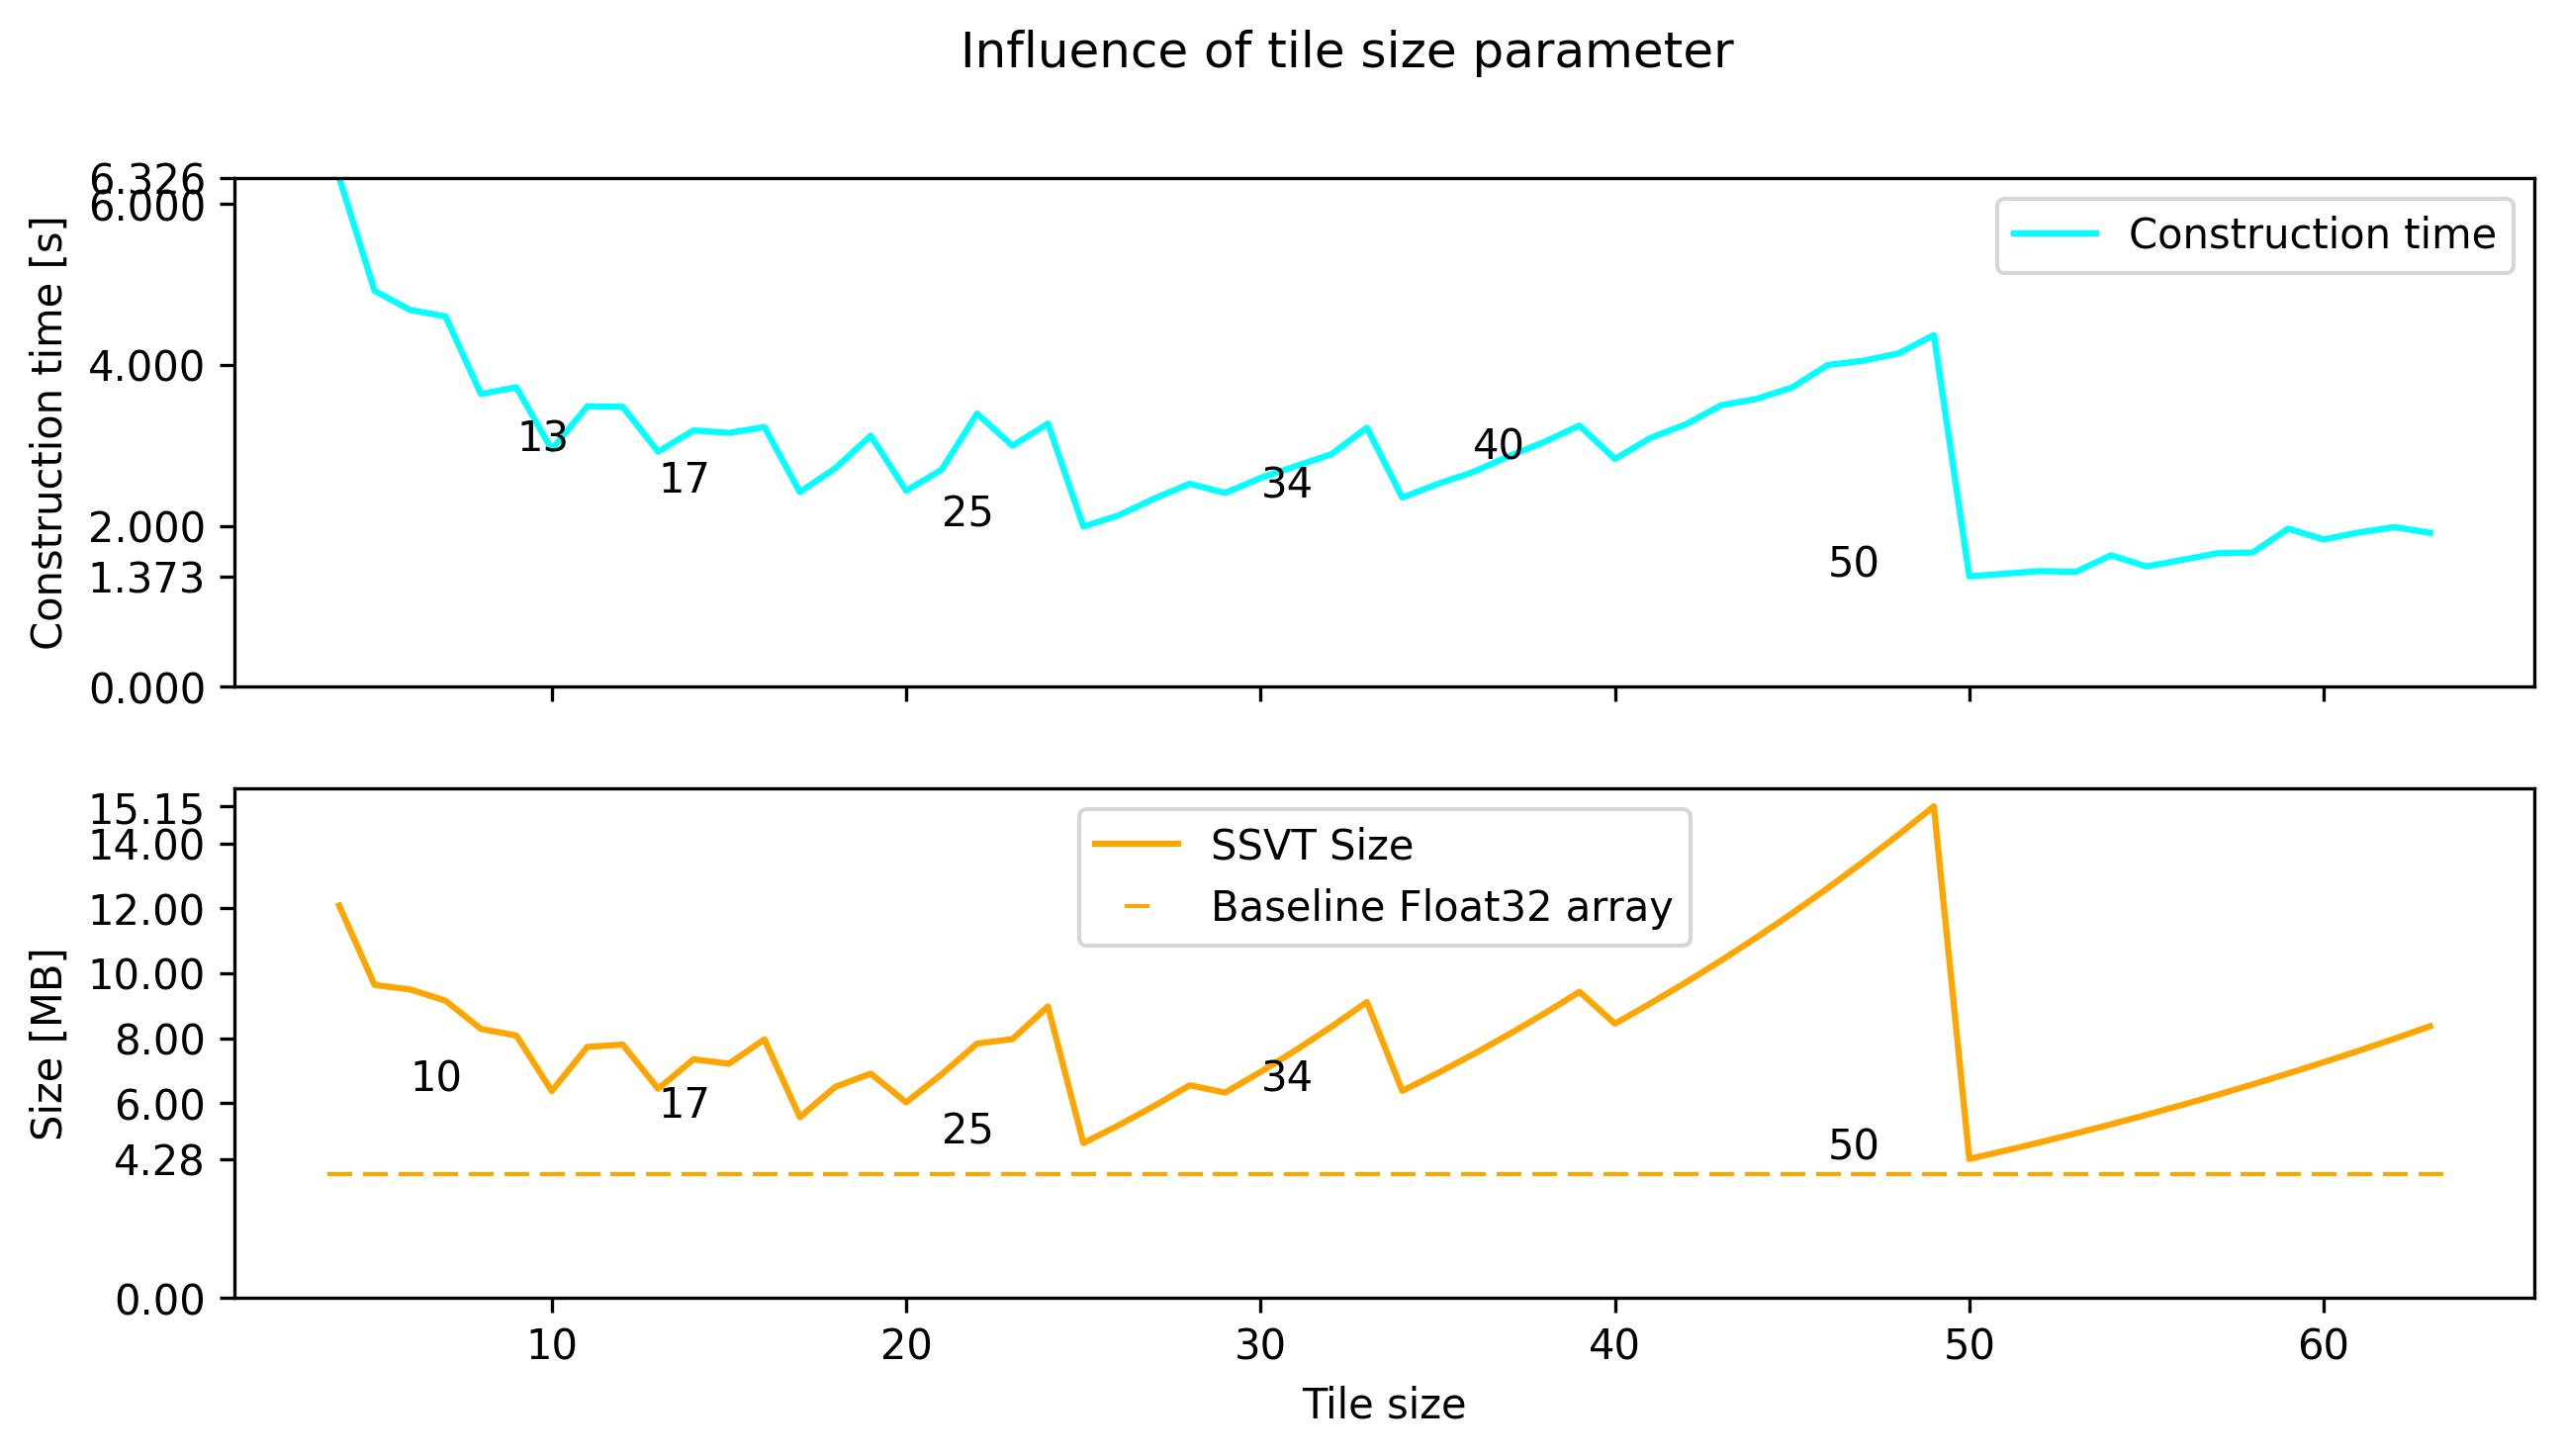

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import argrelmin

def minima(value_array, axes=None, anotate=True):
    minima_indices = argrelmin(value_array, order=3)[0]
    if anotate:
        for minimum in zip(minima_indices, value_array[minima_indices]):
            axes.annotate(f'{tile_sizes[minimum[0]]}', minimum)
    return minima_indices

def min_max_ticks(value_array):
    low, high = np.min(value_array), np.max(value_array)
    r = np.arange(2* ((low // 2) + 1), 2* ((high // 2)+1), 2)
    return [0, low, *r, high]


fig = plt.figure(figsize=(10,5), dpi=300)
(ax1, ax2) = fig.subplots(2,1, sharex=True)
fig.suptitle('Influence of tile size parameter')

ax1.set_ylim(0)
ax1.set_ylabel('Construction time [s]')
ax1.set_yticks(min_max_ticks(timings))
timeline, = ax1.plot(tile_sizes, timings, color='cyan', label='Construction time')
ax1.legend(handles=[timeline])

#ax2 = ax1.twinx()
sizeline, = ax2.plot(tile_sizes, sizes, color='orange', label='SSVT Size')
ax2.set_xlabel('Tile size')
ax2.set_ylim(0)
ax2.set_ylabel('Size [MB]')
ax2.set_yticks(min_max_ticks(sizes))
baseline, = ax2.plot(tile_sizes, np.repeat(raw_data_size, len(tile_sizes)), '_', color='orange', label='Baseline Float32 array')
ax2.legend(handles=[sizeline, baseline])
minima(timings, ax1)
minima(sizes, ax2);
#plt.xticks(tile_sizes)
plt.savefig('tile_size.png')

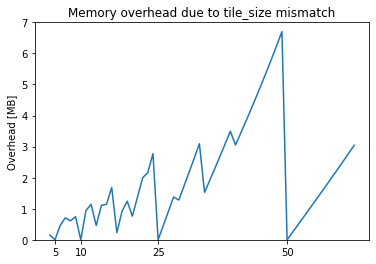

In [6]:
fig, ax1 = plt.subplots()
plt.plot(tile_sizes, overhead_size)
plt.ylabel('Overhead [MB]')
plt.ylim(0, 7)
plt.title('Memory overhead due to tile_size mismatch')
plt.xticks(tile_sizes[overhead_size == 0.0]);
# ax2 = ax1.twinx()
# ax2.plot(tile_sizes, sizes - overhead_size, 'r')
# ax2.set_ylabel('Overhead [%]')
#ax2.set_ylim(0.0, 1.0)
